In [23]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from training import train
from models import *
from A2C_agent import *
from helpers import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# VANILLA A2C IMPLEMENTATION 

In [24]:
device = device_selection() # mps -> cuda -> cpu
print(device)

# Initialize environment
env = gym.make('CartPole-v1') 

# hyperparameters
gamma_ = 0.99
lr_actor = 1e-5
lr_critic = 1e-3
eps = 0.1
num_episodes = 10000
total_steps_budget = 500000
max_steps_per_episode = 1000

# neural network structure
input_size = env.observation_space.shape[0] # 4
hidden_size = 64
output_size_actor = env.action_space.n # 2
output_size_critic = 1


# Initialize agent 
agent = Agent(input_size, hidden_size, \
                output_size_actor, output_size_critic, \
                eps, gamma_, lr_actor, lr_critic, \
                device=device)

# Initialize batch
batch = []
critic_losses = []
actor_losses = []
episode_rewards = []
evaluation_results = []

for episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.from_numpy(state).float().to(device)  # Convert state to a tensor
    episode_reward = 0

    for t in range(max_steps_per_episode):

        action = agent.select_action(state, policy="eps-greedy")
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        agent.num_steps += 1
        next_state = torch.from_numpy(next_state).float().to(device)  # Convert next_state to a tensor
        done = terminated or truncated
        episode_reward += reward

        # Add the experience to the batch
        experience = (state, action, reward, next_state, terminated)

        # Train the agent
        actor_loss, critic_loss = train(agent, experience)
        critic_losses.append(critic_loss)
        actor_losses.append(actor_loss)

        state = next_state

        if done: break
        
        if agent.num_steps % 20000 == 0: 
            print("---- Proceeding to evaluate model ... ----")
            mean_reward, std_reward, value_trajectories = agent.evaluate_agent(num_episodes=10)
            evaluation_results.append((mean_reward,std_reward))
            print(f"Mean reward: {mean_reward:.2f}, Std reward: {std_reward:.2f}")
            print("----     Evaluation finished        ----")

    episode_rewards.append(episode_reward)
    if episode % 100 == 0:
        print(f"Episode {episode} finished after {t+1} steps with reward {episode_reward}")
        print(f"Actor loss: {actor_losses[-1]:.4f}, Critic loss: {critic_losses[-1]:.4f}")
        print(f"Total steps taken during training: {agent.num_steps}")
    
    if (agent.num_steps >= total_steps_budget): 
        print(f"Reached total training budget of {total_steps_budget} steps ----> Stopping training at episode {episode}")
        break



mps
Episode 0 finished after 29 steps with reward 29.0
Actor loss: 0.5941, Critic loss: 0.3687
Total steps taken during training: 29
Episode 100 finished after 17 steps with reward 17.0
Actor loss: 1.2710, Critic loss: 1.9137
Total steps taken during training: 1658
Episode 200 finished after 19 steps with reward 19.0
Actor loss: 0.1630, Critic loss: 0.0347
Total steps taken during training: 3492
Episode 300 finished after 19 steps with reward 19.0
Actor loss: 0.5538, Critic loss: 0.3857
Total steps taken during training: 5231
Episode 400 finished after 15 steps with reward 15.0
Actor loss: -1.0618, Critic loss: 1.4301
Total steps taken during training: 7010
Episode 500 finished after 21 steps with reward 21.0
Actor loss: 0.4796, Critic loss: 0.3032
Total steps taken during training: 8704
Episode 600 finished after 24 steps with reward 24.0
Actor loss: 0.5990, Critic loss: 0.4541
Total steps taken during training: 10655
Episode 700 finished after 22 steps with reward 22.0
Actor loss: -0

KeyboardInterrupt: 

workers all use the same parameters and get updated with the same gradient at the same time (if not at the same time --> updates with different policies by definition, but A2C is on-policy). Doesn't matter if they (inevitably) end episodes at different time-steps. What matters is they have the same policy when accumulating a batch (same actor-critic params).

batches vanilla are (1x1), in general (num_time_steps x num_workers)

In [27]:
# Initialize batch
critic_losses = []
actor_losses = []
episode_rewards_test = []
num_episodes_test = 100

for episode in range(num_episodes_test):
    state, _ = env.reset()
    state = torch.from_numpy(state).float().to(device)  # Convert state to a tensor

    episode_reward = 0

    for t in range(max_steps_per_episode):
        action = agent.select_action(state, policy="greedy")
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        agent.num_steps += 1
        
        next_state = torch.from_numpy(next_state).float().to(device)  # Convert next_state to a tensor
        done = terminated or truncated
        episode_reward += reward
        
        state = next_state
        if done: break
    episode_rewards_test.append(episode_reward)
    print(f"Episode {episode} finished after {t+1} steps with reward {episode_reward:.2f}")

print(f"Average reward over {num_episodes_test} episodes: {np.mean(episode_rewards_test):.2f}")


Episode 0 finished after 28 steps with reward 28.00
Episode 1 finished after 18 steps with reward 18.00
Episode 2 finished after 23 steps with reward 23.00
Episode 3 finished after 20 steps with reward 20.00
Episode 4 finished after 21 steps with reward 21.00
Episode 5 finished after 20 steps with reward 20.00
Episode 6 finished after 22 steps with reward 22.00
Episode 7 finished after 20 steps with reward 20.00
Episode 8 finished after 22 steps with reward 22.00
Episode 9 finished after 21 steps with reward 21.00
Episode 10 finished after 30 steps with reward 30.00
Episode 11 finished after 26 steps with reward 26.00
Episode 12 finished after 20 steps with reward 20.00
Episode 13 finished after 18 steps with reward 18.00
Episode 14 finished after 21 steps with reward 21.00
Episode 15 finished after 22 steps with reward 22.00
Episode 16 finished after 26 steps with reward 26.00
Episode 17 finished after 23 steps with reward 23.00
Episode 18 finished after 27 steps with reward 27.00
Epi

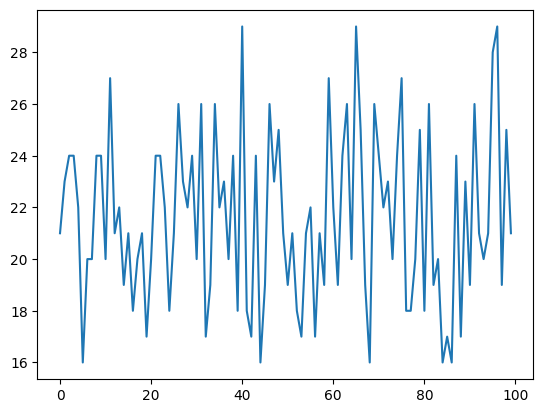

In [26]:
plt.plot(episode_rewards)

In [29]:
critic_losses

[]

In [30]:
actor_losses

[]